In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Anorthodox bracketing - bisection

In [2]:
#The commented out section is basically the general idea behind bracketing. Trying to
#find an eigenvalue in a certain interval and if it doesnt change that, change the
# interval. This requires a lot of attention and a good idea of what eigenvalues to
#expect. I did not like this idea so instead I am looking in a bigger space with a
#a step, increasing slightly the computational cost but automating the process.

def bracketing(func, x1, x2, FACT): 
    for _ in range(100000):
        if func(x1) * func(x2) < 0:
            return x1, x2
        else:
            break
        # if abs(func(x1)) < abs(func(x2)):
        #     x1 += FACT * (x1 - x2)
        # else:
        #     x2 += FACT * (x2 - x1)
    raise ValueError("Failed to bracket the root.")      

def bisection(func,a,b,err):
    f_a, f_b = func(a), func(b)
    if f_a * f_b > 0:
        raise ValueError("The f(a)*f(b)<0 condition is not met.")
    while True:
        c = (a+b)/2
        f_c = func(c)

        if abs(f_c) < err:
            return c

        if f_c * f_a > 0:
            a,f_a = c, f_c
        else:
            b,f_b = c, f_c

## Particle in infinite square potential

In [3]:
def numerov_inf(k,N,h,eig):
    delta = 0.8
    phi = np.zeros(N)
    phi[1] = delta * h #perturbation
    w = np.zeros(N)

    for i in range(1, N-1):
        w[i] = 2 * (1 - (5 * h **2 /12) * 2 *(eig - k[i]))
        w[i-1] = - (1 + (h ** 2/12) * 2 * (eig - k[i-1]))
        w[i+1] = (1 + (h**2/12)* 2 * (eig - k[i+1]))

        if i + 1 < N:
            phi[i+1] = (1 / w[i+1]) * (w[i] * phi[i] + w[i-1] * phi[i-1])
        
    return phi 

def normalize(h,phi):
    norm = np.sqrt(np.sum(phi**2) * h)
    return phi / norm

def func(x):
    return numerov_inf(k,N,h,x)[-1]

In [5]:
# for FACT>=0.5 I get this error and thus keep it 0.4       
# /tmp/ipykernel_6743/2017537716.py:32: RuntimeWarning: overflow encountered in scalar add
#   x2 += + FACT * (x2 - x1)
# /tmp/ipykernel_6743/2017537716.py:30: RuntimeWarning: overflow encountered in scalar add
#   x1 += FACT * (x1 - x2)

### Finding the eigenvalues/eigenfunctions and plotting them

Eigenvalue found in (4, 6): 4.9348
Eigenvalue found in (18, 20): 19.7393
Eigenvalue found in (44, 46): 44.4133
Eigenvalue found in (78, 80): 78.9570


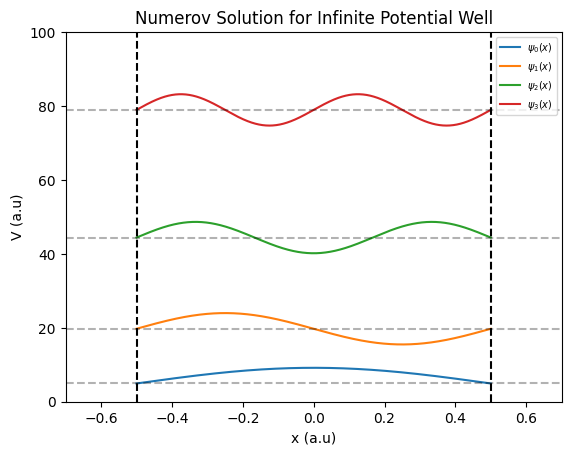

In [4]:
N, err, FACT, max_iter  = 1000, 1e-6, 0.4, 2000
x = np.linspace(-0.5,0.5,N)
h = x[1] - x[0]
k = np.where((-0.5 <= x) & (x <= 0.5), 0, 1e-6)

eigenvalues = []
start, end, step = 0, 90, 2

for int_left in np.arange(start,end,step):
    int_right = int_left + step
    try:
        k1, k2 = bracketing(func, int_left, int_right, FACT)
        eigen = bisection(func, k1, k2, err)
        eigenvalues.append(eigen)
        print(f"Eigenvalue found in ({int_left}, {int_right}): {eigen:.4f}")
    except ValueError:
        pass

        
for idx, eig in enumerate(eigenvalues):
    phi = numerov_inf(k, N, h, eig)
    phi_norm = normalize(h, phi)
    plt.plot(x, 3*phi_norm + eig, label=f"$\\psi_{idx}(x)$") 

plt.axvline(-0.5, color="black", linestyle="--")
plt.axvline(0.5, color="black", linestyle="--")
plt.axhline(y=4.9348,color='black',linestyle='--',alpha=0.3)
plt.axhline(y=19.7393,color='black',linestyle='--',alpha=0.3)
plt.axhline(y=44.4133,color='black',linestyle='--',alpha=0.3)
plt.axhline(y=78.9570,color='black',linestyle='--',alpha=0.3)
plt.xlim(-0.7, 0.7)
plt.ylim(0, 100)
plt.xlabel("x (a.u)")
plt.ylabel("V (a.u)")
plt.title("Numerov Solution for Infinite Potential Well")
plt.legend(fontsize = 7)
plt.savefig("infwell")
plt.show()

## Finite Potential Well

### numerov finite

In [5]:
def numerov_finite(V,N,h,eig,m):
    delta = 0.5
    phiL, phiR = np.zeros(N), np.zeros(N)
    phiL[0], phiL[1] = 0, delta*h
    phiR[-1], phiR[-2] = 0, delta*h
    
    w = np.zeros(N)
    yMax = 0
    
    for i in range(1, m+1):
        w[i] = 2 * (1 - (5*(h**2)/12) * 2 *(eig - V[i]))
        w[i-1] = - (1 + ((h**2)/12) * 2 * (eig - V[i-1]))
        w[i+1] = (1 + ((h**2)/12) * 2 * (eig - V[i+1]))
        phiL[i+1] = (1/w[i+1]) * (w[i] * phiL[i] + w[i-1] * phiL[i-1])
        
        if phiL[i+1] > yMax:
            yMax = phiL[i+1]
        
        if phiL[i+1] > 1E6:
            phiL[:i+1] *= 1E-6
            yMax *= 1E-6
    
    for i in range(N-2, m-1, -1):
        w[i] = 2 * (1 - (5 * (h ** 2)/12) * 2 * (eig - V[i]))
        w[i-1] = (1 + ((h ** 2)/12) * 2 * (eig - V[i-1]))
        w[i+1] = -(1 + ((h ** 2)/12) * 2 * (eig - V[i+1]))
        phiR[i-1] = (1/w[i-1]) * (w[i] * phiR[i] + w[i+1] * phiR[i+1])
        
        if phiR[i-1] > yMax:
            yMax = phiR[i-1]
        
        if phiR[i-1] > 1E6:
            phiR[i-1:N] *= 1E-6
            yMax *= 1E-6
    
    phiL[:m+1] *= phiR[m] / phiL[m]
    
    derL = (phiL[m] - phiL[m-2]) 
    derR = (phiR[m+1] - phiR[m-1]) 
    numerov_value = (derL-derR)/yMax
    phi = np.concatenate([phiL[:m+1], phiR[m+1:]]) #combines phiL and phiR in a single array
    
    return numerov_value, phi

def func_finite(eig):
    return numerov_finite(V, N, h, eig, m)[0]

### finding amount of eigenvalues and the exact eigenvalues

Eigenvalue found in (0.5, 1.0): 0.8192
Eigenvalue found in (3.0, 3.5): 3.2252
Eigenvalue found in (6.5, 7.0): 6.9731


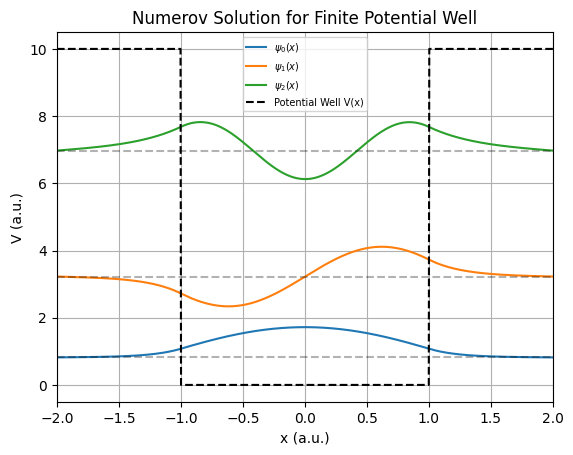

In [6]:
L, V0, N= 2,10,1000
m = 300
x = np.linspace(-L, L, N)
h = x[1] - x[0]
V = np.array([0 if abs(xi) < L/2 else V0 for xi in x])

eigenvalues = []
start, end, step = 0, 10, 0.5

for int_left in np.arange(start,end,step):
    int_right = int_left + step
    try:
        k1, k2 = bracketing(func_finite, int_left, int_right, FACT)
        eigen = bisection(func_finite, k1, k2, err)
        eigenvalues.append(eigen)
        print(f"Eigenvalue found in ({int_left}, {int_right}): {eigen:.4f}")
    except ValueError:
        pass

        
for idx, eig in enumerate(eigenvalues):
    _, phi = numerov_finite(V, N, h, eig, m)
    phi_norm = normalize(h, phi)
    plt.plot(x, phi_norm + eig, label=f"$\\psi_{idx}(x)$") 

plt.plot(x, V, 'k--', label="Potential Well V(x)")
plt.xlim(-L,L)
plt.axhline(y=0.8192,color='black',linestyle='--',alpha=0.3)
plt.axhline(y=3.2252,color='black',linestyle='--',alpha=0.3)
plt.axhline(y=6.9731,color='black',linestyle='--',alpha=0.3)
plt.xlabel("x (a.u.)")
plt.ylabel("V (a.u.)")
plt.title("Numerov Solution for Finite Potential Well")
plt.legend(fontsize=7)
plt.grid()
plt.savefig("finwell1")
plt.show()

## Double Well

### Double well function

In [7]:
def numerov_double(V,N,h,eig,m):
    delta = 0.5
    phiL, phiR = np.zeros(N), np.zeros(N)
    phiL[0], phiL[1] = 0, delta*h
    phiR[-1], phiR[-2] = 0, delta*h
    
    w = np.zeros(N)
    yMax = 0
    
    for i in range(1, m+1):
        w[i] = 2 * (1 - (5*(h**2)/12) * 2 *(eig - V[i]))
        w[i-1] = - (1 + ((h**2)/12) * 2 * (eig - V[i-1]))
        w[i+1] = (1 + ((h**2)/12) * 2 * (eig - V[i+1]))
        phiL[i+1] = (1/w[i+1]) * (w[i] * phiL[i] + w[i-1] * phiL[i-1])
        
        if phiL[i+1] > yMax:
            yMax = phiL[i+1]
        
        if phiL[i+1] > 1E6:
            phiL[:i+1] *= 1E-6
            yMax *= 1E-6
    
    for i in range(N-2, m-1, -1):
        w[i] = 2 * (1 - (5 * (h ** 2)/12) * 2 * (eig - V[i]))
        w[i-1] = (1 + ((h ** 2)/12) * 2 * (eig - V[i-1]))
        w[i+1] = -(1 + ((h ** 2)/12) * 2 * (eig - V[i+1]))
        phiR[i-1] = (1/w[i-1]) * (w[i] * phiR[i] + w[i+1] * phiR[i+1])
        
        if phiR[i-1] > yMax:
            yMax = phiR[i-1]
        
        if phiR[i-1] > 1E6:
            phiR[i-1:N] *= 1E-6
            yMax *= 1E-6
    
    phiL[:m+1] *= phiR[m] / phiL[m]
    
    derL = (phiL[m] - phiL[m-2]) 
    derR = (phiR[m+1] - phiR[m-1]) 
    numerov_value = (derL-derR)/yMax
    phi = np.concatenate([phiL[:m+1], phiR[m+1:]]) #combines phiL and phiR in a single array
    
    return numerov_value, phi

def func_double(eig):
    return numerov_double(V, N, h, eig, m)[0]

def normalize(h,phi):
    norm = np.sqrt(np.sum(phi**2) * h)
    return phi / norm

def double_well(x, V0, L, d):
    left_well = (x >= -d/2 - L/2) & (x <= -d/2 + L/2)
    right_well = (x >= d/2 - L/2) & (x <= d/2 + L/2)
    
    V = np.zeros_like(x)
    V[left_well | right_well] = -V0
    
    return V

### finding amount of eigenvalues and the exact eigenvalues

Eigenvalue found in (-0.6599999999999997, -0.6399999999999997): -0.6581
Eigenvalue found in (-0.3399999999999994, -0.3199999999999994): -0.3211


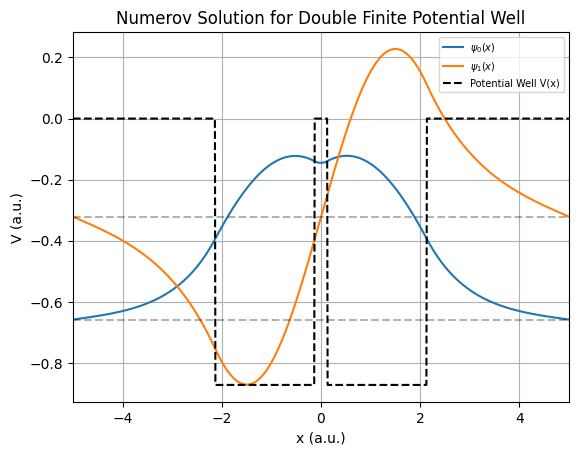

In [8]:
L, V0, N, d, FACT, err= 2,0.872,1000, 2.26, 0.4, 1e-6
x = np.linspace(-5, 5, N)
m = np.argmin(np.abs(x - (-d/2 - L/2))) + 20
h = x[1] - x[0]
V = double_well(x,V0,L,d)

eigenvalues = []
start, end, step = -1, 0, 0.02

for int_left in np.arange(start,end,step):
    int_right = int_left + step
    try:
        k1, k2 = bracketing(func_double, int_left, int_right, FACT)
        eigen = bisection(func_double, k1, k2, err)
        eigenvalues.append(eigen)
        print(f"Eigenvalue found in ({int_left}, {int_right}): {eigen:.4f}")
    except ValueError:
        pass

        
for idx, eig in enumerate(eigenvalues):
    _, phi = numerov_double(V, N, h, eig, m)
    phi_norm = normalize(h, phi)
    plt.plot(x, phi_norm + eig, label=f"$\\psi_{idx}(x)$") 

plt.plot(x, V, 'k--', label="Potential Well V(x)")
plt.xlim(-5,5)
plt.axhline(y=-0.6581,color='black',linestyle='--',alpha=0.3)
plt.axhline(y=-0.3211,color='black',linestyle='--',alpha=0.3)
plt.xlabel("x (a.u.)")
plt.ylabel("V (a.u.)")
plt.title("Numerov Solution for Double Finite Potential Well")
plt.legend(fontsize=7)
plt.grid()
plt.savefig("doublewell")
plt.show()

In [10]:
L, V0, N, d, FACT, err= 2,0.872,1000, 5, 0.4, 1e-6
x = np.linspace(-5, 5, N)
m = np.argmin(np.abs(x - (-d/2 - L/2))) + 20
h = x[1] - x[0]
V = double_well(x,V0,L,d)

eigenvalues = []
start, end, step = -1, 0, 0.02

for int_left in np.arange(start,end,step):
    int_right = int_left + step
    try:
        k1, k2 = bracketing(func_double, int_left, int_right, FACT)
        eigen = bisection(func_double, k1, k2, err)
        eigenvalues.append(eigen)
        print(f"Eigenvalue found in ({int_left}, {int_right}): {eigen:.4f}")
    except ValueError:
        pass

Eigenvalue found in (-0.5199999999999996, -0.49999999999999956): -0.5014
Eigenvalue found in (-0.47999999999999954, -0.4599999999999995): -0.4784


## The Quantum Harmonic Oscillator

Eigenvalue found in (0.0, 0.5): 0.5000
Eigenvalue found in (1.0, 1.5): 1.5000
Eigenvalue found in (2.0, 2.5): 2.4999
Eigenvalue found in (3.0, 3.5): 3.4997
Eigenvalue found in (4.0, 4.5): 4.4995


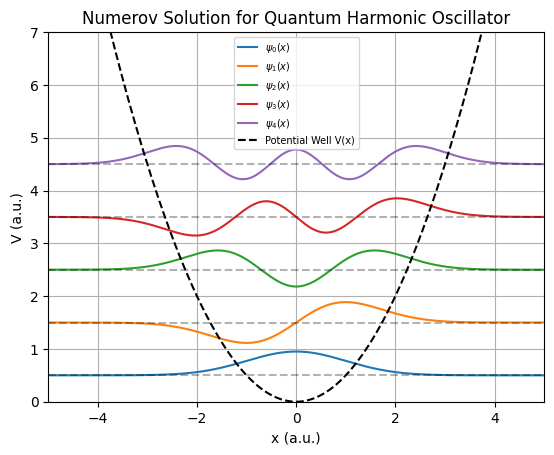

In [11]:
N = 1000
x = np.linspace(-5, 5, N)
h = x[1] - x[0]
V = 0.5 * x **2  

eigenvalues = []
start, end, step = 0, 5, 0.5

for int_left in np.arange(start,end,step):
    int_right = int_left + step
    try:
        k1, k2 = bracketing(func_finite, int_left, int_right, FACT)
        eigen = bisection(func_finite, k1, k2, err)
        eigenvalues.append(eigen)
        print(f"Eigenvalue found in ({int_left}, {int_right}): {eigen:.4f}")
    except ValueError:
        pass


def x_to_index(x, x_min=-5, x_max=5, num=1000):
    return int(round((x - x_min) / (x_max - x_min) * (num - 1)))
    
for idx, eig in enumerate(eigenvalues):
    m = x_to_index(-np.sqrt(2*eig)) + 10
    _, phi = numerov_finite(V, N, h, eig, m)
    phi_norm = normalize(h, phi)
    plt.plot(x, 0.6 * phi_norm + eig, label=f"$\\psi_{idx}(x)$") 

plt.plot(x, V, 'k--', label="Potential Well V(x)")
plt.xlim(-5,5)
plt.axhline(y=0.5000,color='black',linestyle='--',alpha=0.3)
plt.axhline(y=1.4999,color='black',linestyle='--',alpha=0.3)
plt.axhline(y=2.4997,color='black',linestyle='--',alpha=0.3)
plt.axhline(y=3.4995,color='black',linestyle='--',alpha=0.3)
plt.axhline(y=4.5005,color='black',linestyle='--',alpha=0.3)
plt.ylim(0, 7)
plt.xlabel("x (a.u.)")
plt.ylabel("V (a.u.)")
plt.title("Numerov Solution for Quantum Harmonic Oscillator")
plt.legend(fontsize = 7)
plt.savefig("quantum1")
plt.grid()
plt.show()

## The radial Schrodinger equation

In [12]:
def potential(r, l):
    return ((l * (l + 1)) / r**2) - 2 / r

def numerov_schro(V, N, h, eig, r0):
    delta = 0.5
    u = np.zeros(N)
    u[-2] = u[-1] + delta * h
    
    w = np.zeros(N)
    yMax = 0
    
    for i in range(N - 2, 0, -1):
        w[i] = 2 * (1 - (5 * (h ** 2) / 12) * 2 * (eig - V[i]))
        w[i - 1] = (1 + ((h ** 2) / 12) * 2 * (eig - V[i - 1]))
        w[i + 1] = - (1 + ((h ** 2) / 12) * 2 * (eig - V[i + 1]))
        
        u[i - 1] = (1 / w[i - 1]) * (w[i] * u[i] + w[i + 1] * u[i + 1])
        
        if abs(u[i - 1]) > 1e6:
            u[i - 1:] /= 1e6
    
    numerov_value = u[0] - ((u[1] - u[0]) / h) * r0  # Ensure boundary condition u(0) = 0
    
    return numerov_value, u

def root_schro(x):
    return numerov_schro(V, N, h, x, r0)[0]

Eigenvalue found in (-1.9999999999999991, -1.899999999999999): -1.9999
Eigenvalue found in (-0.4999999999999978, -0.3999999999999978): -0.5000
Eigenvalue found in (-0.2999999999999976, -0.1999999999999976): -0.2222
Eigenvalue found in (-0.1999999999999975, -0.09999999999999751): -0.1222


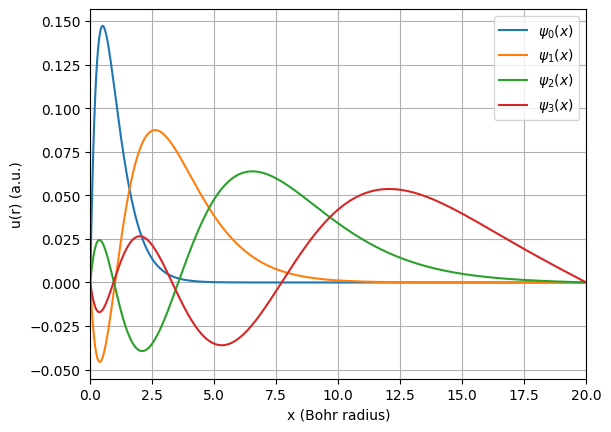

In [13]:
L, N, d, FACT, err = 1, 1000, 2.26, 0.4, 1e-6
r0 = 1e-6
r_max = 20
x = np.linspace(r0, r_max, num=N)
h = x[-1] - x[-2]
m = np.argmin(np.abs(x - (d/2 + L/2))) + 20
V = potential(x, 0)

eigenvalues = []
start, end, step = -3, -0.1, 0.1

for int_left in np.arange(start, end, step):
    int_right = int_left + step
    try:
        k1, k2 = bracketing(root_schro, int_left, int_right, FACT)
        eigen = bisection(root_schro, k1, k2, err)
        eigenvalues.append(eigen)
        print(f"Eigenvalue found in ({int_left}, {int_right}): {eigen:.4f}")
    except ValueError:
        pass

for idx, eig in enumerate(eigenvalues):
    _, phi = numerov_schro(V, N, h, eig, r0)
    phi_norm = phi / np.linalg.norm(phi) 
    plt.plot(x, phi_norm, label=f"$\\psi_{idx}(x)$")

plt.xlim(0,20)
plt.xlabel("x (Bohr radius)")
plt.ylabel("u(r) (a.u.)")
plt.legend()
plt.grid()
plt.savefig("radial")
plt.show()

## Bonus

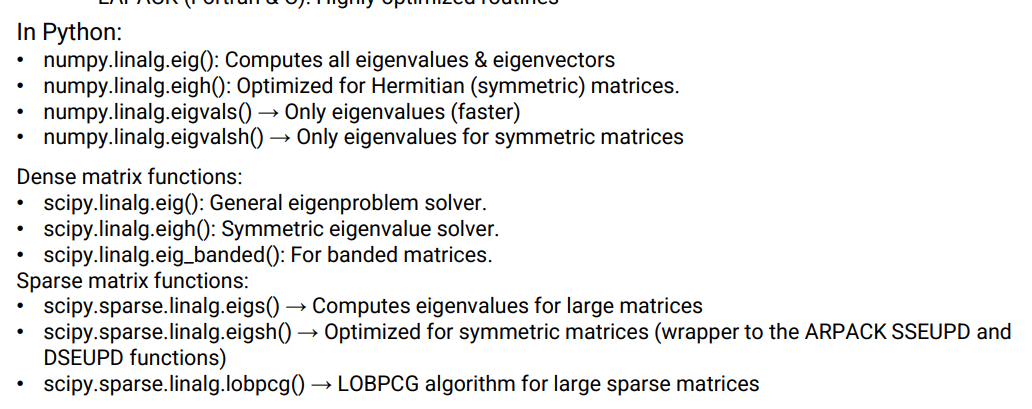

In [4]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

### Discr. Finite

In [20]:
N, L, V0 = 1000, 2, 10
x = np.linspace(-L, L, N)
h = x[1] - x[0]
V = np.array([0 if abs(xi) < L/2 else V0 for xi in x])

# Hamiltonian / (1/h**2) is IMPORTANT —  do not skip it like I did (mistake which showed I was not understanding the point of it)
# Since we’re discretizing the equation, we NEED NEED NEED a step factor as we move to each interval.
main_diag = V + 1/h**2
off_diag = -0.5 / h**2 * np.ones(N - 1)

H = sp.diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], format='csc')
eigenvalues, eigenvectors = spla.eigsh(H, k=3, which='SA')

print("First 3 energy eigenvalues:")
for idx, ev in enumerate(eigenvalues):
    print(f"  E{idx} = {ev:.4f}")

First 3 energy eigenvalues:
  E0 = 0.8185
  E1 = 3.2170
  E2 = 6.9530


### Discr. Oscillator

In [6]:
L, N = 5, 1000  
x = np.linspace(-L, L, N)
h = x[1] - x[0]  
V = 0.5 * x**2

main_diag = V + 1 / h**2
off_diag = -0.5 / h**2 * np.ones(N - 1)

H = sp.diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], format='csc')

eigenvalues, eigenvectors = spla.eigsh(H, k=5, which='SA')

print("First 5 energy eigenvalues:")
for idx, ev in enumerate(eigenvalues):
    print(f"  E{idx} = {ev:.4f}")

First 5 energy eigenvalues:
  E0 = 0.5000
  E1 = 1.5000
  E2 = 2.5000
  E3 = 3.4999
  E4 = 4.4999


### calc percentag. differences

In [22]:
E0_fin_discr = 0.8185
E1_fin_discr = 3.2170
E2_fin_discr = 6.9530

E0_fin_num = 0.8192
E1_fin_num  = 3.2252
E2_fin_num  = 6.9731

E0_hosc_discr = 0.5000
E1_hosc_discr  = 1.5000
E2_hosc_discr = 2.5000
E3_hosc_discr = 3.4999
E4_hosc_discr = 4.4999

E0_hosc_num = 0.5000v
E1_hosc_num  = 1.4999
E2_hosc_num = 2.4997
E3_hosc_num = 3.4995
E4_hosc_num = 4.5005

In [23]:
def percentage_error(true_value, measured_value):
    return abs((measured_value - true_value) / true_value) * 100

errors = {
    "E0_fin": percentage_error(E0_fin_discr, E0_fin_num),
    "E1_fin": percentage_error(E1_fin_discr, E1_fin_num),
    "E2_fin": percentage_error(E2_fin_discr, E2_fin_num),
    "E0_hosc": percentage_error(E0_hosc_discr, E0_hosc_num),
    "E1_hosc": percentage_error(E1_hosc_discr, E1_hosc_num),
    "E2_hosc": percentage_error(E2_hosc_discr, E2_hosc_num),
    "E3_hosc": percentage_error(E3_hosc_discr, E3_hosc_num),
    "E4_hosc": percentage_error(E4_hosc_discr, E4_hosc_num),
}

for key, value in errors.items():
    print(f"{key}: {value:.4f}%")

E0_fin: 0.0855%
E1_fin: 0.2549%
E2_fin: 0.2891%
E0_hosc: 0.0000%
E1_hosc: 0.0067%
E2_hosc: 0.0120%
E3_hosc: 0.0114%
E4_hosc: 0.0133%
